In [1]:
!nvidia-smi

Fri May  9 09:45:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
!ls /kaggle/input/car-dataset


data.yaml  export  README.dataset.txt  README.roboflow.txt


In [4]:
!mkdir /kaggle/working/yolo11
ROOT_DIR = '/kaggle/working/yolo11'

In [5]:
!pip install ultralytics
!pip install Ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [6]:
import matplotlib.pyplot as plt
from IPython.display import Image as imgshow
import os
import random
from concurrent.futures import ProcessPoolExecutor
import shutil
import pandas as pd

In [7]:
!mkdir /kaggle/working/data

In [8]:
cp -r /kaggle/input/car-dataset/export /kaggle/working/data

**Data Preprocessing**

In [9]:
import os
import random
import shutil

# Paths
base_dir = '/kaggle/working/data/export'   # Change this to your actual export directory
images_dir = os.path.join(base_dir, 'images')
labels_dir = os.path.join(base_dir, 'labels')

# Output folders
output_dir = '/kaggle/working/training_data'  # where you want the split data
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, 'labels'), exist_ok=True)

# List all images
images = os.listdir(images_dir)
images = [img for img in images if img.endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle
random.shuffle(images)

# Split
n_total = len(images)
n_train = int(n_total * 0.8)
n_val = int(n_total * 0.1)
n_test = n_total - n_train - n_val

train_images = images[:n_train]
val_images = images[n_train:n_train+n_val]
test_images = images[n_train+n_val:]

# Function to copy images and labels
def copy_files(image_list, split):
    for img_name in image_list:
        # Copy image
        shutil.copy2(os.path.join(images_dir, img_name), os.path.join(output_dir, split, 'images', img_name))
        
        # Copy label
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_name)
        if os.path.exists(label_path):
            shutil.copy2(label_path, os.path.join(output_dir, split, 'labels', label_name))

# Copy files
copy_files(train_images, 'train')
copy_files(val_images, 'val')
copy_files(test_images, 'test')

print("Dataset split completed successfully!")


Dataset split completed successfully!


**Creating .Yaml file**

In [10]:
# Define paths
output_folder = '/kaggle/working/training_data'

# Create dataset.yaml content
dataset_yaml_content = """
# train and val and test data
train: /kaggle/working/training_data/train/images
val: /kaggle/working/training_data/val/images
test: /kaggle/working/training_data/test/images

# number of classes
nc: 11
names: ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']

"""

# Save dataset.yaml file
os.makedirs(output_folder, exist_ok=True)
with open(os.path.join(output_folder, 'dataset.yaml'), 'w') as f:
    f.write(dataset_yaml_content)

print("dataset.yaml file created successfully.")

dataset.yaml file created successfully.


**Training**

In [1]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11m.pt")

# Train the model on the COCO8 example dataset for 20 epochs
results = model.train(data="/kaggle/working/training_data/dataset.yaml", epochs=40, imgsz=480, batch=8, workers=1)



Ultralytics 8.3.129 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/training_data/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

train: Scanning /kaggle/working/training_data/train/labels... 23840 images, 2813 backgrounds, 0 corrupt: 100%|██████████| 23840/23840 [00:16<00:00, 1419.55it/s]

train: /kaggle/working/training_data/train/images/1478021875081281646_jpg.rf.bEZPhuyXU5hIovwQSTIp.jpg: 1 duplicate labels removed
train: /kaggle/working/training_data/train/images/1478897760163798179_jpg.rf.98623be50b02ff17d58f89fddf7a0c6c.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/training_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 734.0±329.7 MB/s, size: 35.1 KB)


val: Scanning /kaggle/working/training_data/val/labels... 2980 images, 318 backgrounds, 0 corrupt: 100%|██████████| 2980/2980 [00:02<00:00, 1382.87it/s]

val: /kaggle/working/training_data/val/images/1478021875081281646_jpg.rf.e9552980cf8c6fef4aa02cb84c6364f5.jpg: 1 duplicate labels removed
val: /kaggle/working/training_data/val/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed
val: /kaggle/working/training_data/val/images/1478898145212453716_jpg.rf.nCaFkPk4AFMjTQAM4RTJ.jpg: 1 duplicate labels removed


val: New cache created: /kaggle/working/training_data/val/labels.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 1 dataloader workers
Logging results to runs/detect/train3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      2.49G      1.467      1.064      1.101         58        480: 100%|██████████| 2980/2980 [09:29<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:30<00:00,  6.22it/s]


                   all       2980      19505      0.714      0.375        0.4      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      2.95G      1.481      0.957      1.105         75        480: 100%|██████████| 2980/2980 [09:17<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.48it/s]


                   all       2980      19505      0.665      0.357      0.437      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      2.95G      1.526      1.013      1.133         62        480: 100%|██████████| 2980/2980 [09:12<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.49it/s]


                   all       2980      19505      0.522      0.328      0.378      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      2.95G      1.535      1.011      1.143         34        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.50it/s]


                   all       2980      19505      0.526      0.376      0.412      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      2.95G      1.491      0.958      1.125         93        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.50it/s]


                   all       2980      19505      0.703      0.431      0.483      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      2.95G      1.459     0.9118      1.112         47        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.49it/s]


                   all       2980      19505      0.756       0.44      0.497      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      2.95G      1.441     0.8861        1.1        103        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.51it/s]


                   all       2980      19505      0.697       0.48      0.518      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      2.95G      1.412     0.8574      1.089         66        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.54it/s]


                   all       2980      19505      0.758      0.475      0.541      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      2.95G      1.397     0.8384      1.083         88        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.52it/s]


                   all       2980      19505      0.745      0.503      0.555      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      2.95G      1.383     0.8214      1.078         57        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.55it/s]


                   all       2980      19505      0.751      0.502      0.565      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      2.95G      1.369     0.8108       1.07        102        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.54it/s]


                   all       2980      19505       0.78      0.514      0.569      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      2.95G      1.356      0.795      1.068         76        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.55it/s]


                   all       2980      19505        0.8      0.518      0.587      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      2.95G      1.342     0.7841      1.059         53        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.58it/s]


                   all       2980      19505      0.774      0.551      0.611       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      2.95G      1.332     0.7707      1.058         52        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.52it/s]


                   all       2980      19505      0.776      0.545      0.607      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      2.95G      1.323     0.7618      1.052         57        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.51it/s]


                   all       2980      19505      0.762      0.559      0.616       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      2.95G      1.311     0.7513      1.048         83        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.54it/s]


                   all       2980      19505      0.794      0.559      0.621      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      2.95G        1.3     0.7395      1.045         77        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.55it/s]


                   all       2980      19505      0.807      0.562      0.639      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      2.95G      1.291     0.7291      1.042         84        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.55it/s]


                   all       2980      19505      0.791      0.568      0.646      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      2.95G      1.284     0.7242      1.037         63        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.56it/s]


                   all       2980      19505      0.806      0.574      0.656       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      2.95G      1.271     0.7094      1.036         80        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.55it/s]


                   all       2980      19505      0.821      0.571      0.659      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      2.95G      1.266     0.7065      1.031        118        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.55it/s]


                   all       2980      19505      0.806      0.583      0.661       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      2.95G       1.26     0.6994      1.029        102        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.55it/s]


                   all       2980      19505      0.805      0.606      0.671      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      2.95G      1.246     0.6881      1.022         70        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.53it/s]

                   all       2980      19505      0.821      0.614      0.683      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      2.95G      1.234     0.6808      1.019         69        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.57it/s]

                   all       2980      19505      0.831      0.612      0.685      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      2.95G      1.229     0.6744      1.018         40        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.55it/s]

                   all       2980      19505      0.818      0.637      0.691      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      2.95G      1.217     0.6635      1.011         90        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.58it/s]

                   all       2980      19505      0.832      0.633      0.694      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      2.95G      1.212     0.6599      1.012         49        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.55it/s]

                   all       2980      19505      0.832      0.631        0.7      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      2.95G      1.198     0.6496      1.007         35        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.57it/s]

                   all       2980      19505      0.825      0.636      0.701      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      2.95G      1.192     0.6429      1.004         68        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.53it/s]

                   all       2980      19505      0.834      0.633      0.702      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      2.95G      1.185     0.6355      1.002         79        480: 100%|██████████| 2980/2980 [09:11<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.57it/s]

                   all       2980      19505      0.825      0.638      0.705      0.406


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      2.95G      1.199     0.6127      1.006         51        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.51it/s]

                   all       2980      19505      0.843      0.635      0.707      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      2.95G      1.185     0.5991      1.003         55        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.57it/s]

                   all       2980      19505      0.839      0.645      0.712      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      2.95G      1.169     0.5905      0.995         48        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.58it/s]


                   all       2980      19505       0.87      0.627      0.715      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      2.95G      1.155     0.5786     0.9908         30        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.56it/s]

                   all       2980      19505      0.867      0.633      0.719      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      2.95G      1.142     0.5687     0.9864         64        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.56it/s]

                   all       2980      19505       0.86      0.638      0.723      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      2.95G      1.131     0.5618     0.9825         45        480: 100%|██████████| 2980/2980 [09:09<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.58it/s]

                   all       2980      19505       0.86       0.64       0.73      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      2.95G      1.116     0.5542      0.975         63        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.58it/s]

                   all       2980      19505      0.869      0.645      0.731      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      2.95G      1.106     0.5456     0.9724         32        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.57it/s]

                   all       2980      19505      0.781      0.645      0.734      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      2.95G       1.09     0.5354     0.9684         80        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.58it/s]

                   all       2980      19505      0.782      0.647      0.743      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      2.95G      1.082     0.5297     0.9656         35        480: 100%|██████████| 2980/2980 [09:10<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.56it/s]

                   all       2980      19505      0.877      0.644      0.742      0.443



40 epochs completed in 6.455 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 40.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,038,513 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:30<00:00,  6.23it/s]


                   all       2980      19505      0.878      0.644      0.742      0.443
                 biker        257        413      0.826      0.661      0.726      0.433
                   car       2603      12947      0.888      0.819       0.87      0.611
            pedestrian        705       2087      0.788      0.581      0.679      0.364
          trafficLight        300        488      0.873      0.803      0.871      0.539
    trafficLight-Green        360        992       0.85      0.672      0.745      0.364
trafficLight-GreenLeft         39         57      0.873      0.605      0.749      0.431
      trafficLight-Red        545       1379      0.902      0.757      0.848      0.535
  trafficLight-RedLeft        266        348      0.906      0.778      0.865      0.548
   trafficLight-Yellow         21         45      0.894      0.561      0.681      0.321
trafficLight-YellowLeft          1          1          1          0      0.249     0.0746
                 tru

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 5.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train3


In [2]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO("/kaggle/input/yolov11_finetuned/pytorch/default/1/weights/best.pt")

# Train the model on the COCO8 example dataset for 20 epochs
results = model.train(data="/kaggle/working/training_data/dataset.yaml", epochs=20, imgsz=480, batch=8, workers=1)



Ultralytics 8.3.129 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/training_data/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=480, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolov11_finetuned/pytorch/default/1/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

100%|██████████| 755k/755k [00:00<00:00, 16.8MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1135.9±376.8 MB/s, size: 37.5 KB)


train: Scanning /kaggle/working/training_data/train/labels... 23840 images, 2818 backgrounds, 0 corrupt: 100%|██████████| 23840/23840 [00:17<00:00, 1345.07it/s]

train: /kaggle/working/training_data/train/images/1478021875081281646_jpg.rf.bEZPhuyXU5hIovwQSTIp.jpg: 1 duplicate labels removed
train: /kaggle/working/training_data/train/images/1478021875081281646_jpg.rf.e9552980cf8c6fef4aa02cb84c6364f5.jpg: 1 duplicate labels removed
train: /kaggle/working/training_data/train/images/1478897760163798179_jpg.rf.5Pzrj3Eg3vZuyl7ztKAt.jpg: 1 duplicate labels removed
train: /kaggle/working/training_data/train/images/1478897760163798179_jpg.rf.98623be50b02ff17d58f89fddf7a0c6c.jpg: 1 duplicate labels removed
train: /kaggle/working/training_data/train/images/1478898145212453716_jpg.rf.6a92d7d7dd523160c990c4e4375bcea9.jpg: 1 duplicate labels removed
train: /kaggle/working/training_data/train/images/1478898145212453716_jpg.rf.nCaFkPk4AFMjTQAM4RTJ.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/training_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 983.2±435.8 MB/s, size: 35.8 KB)


val: Scanning /kaggle/working/training_data/val/labels... 2980 images, 371 backgrounds, 0 corrupt: 100%|██████████| 2980/2980 [00:02<00:00, 1387.04it/s]


val: New cache created: /kaggle/working/training_data/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 1 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.54G      1.175     0.6273          1         49        480: 100%|██████████| 2980/2980 [09:27<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:29<00:00,  6.39it/s]


                   all       2980      19048       0.65        0.7      0.749      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.99G      1.247     0.6898       1.03         71        480: 100%|██████████| 2980/2980 [09:09<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.70it/s]


                   all       2980      19048      0.819      0.601      0.731      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         3G      1.269      0.712      1.042         49        480: 100%|██████████| 2980/2980 [09:05<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.54it/s]


                   all       2980      19048      0.806      0.591      0.707      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         3G      1.271     0.7117      1.047         29        480: 100%|██████████| 2980/2980 [09:01<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.75it/s]


                   all       2980      19048      0.808      0.591      0.746      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         3G      1.257     0.6972      1.037         77        480: 100%|██████████| 2980/2980 [08:58<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.75it/s]


                   all       2980      19048      0.644      0.686      0.751      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         3G      1.238     0.6817       1.03         51        480: 100%|██████████| 2980/2980 [09:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.68it/s]


                   all       2980      19048      0.712      0.657       0.71      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         3G       1.23     0.6719      1.026         54        480: 100%|██████████| 2980/2980 [08:59<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.75it/s]


                   all       2980      19048      0.824      0.616      0.756      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         3G      1.213     0.6603      1.021         55        480: 100%|██████████| 2980/2980 [09:00<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.69it/s]

                   all       2980      19048      0.832       0.63      0.733      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         3G      1.199     0.6444      1.014         75        480: 100%|██████████| 2980/2980 [09:00<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.73it/s]

                   all       2980      19048      0.744       0.68      0.744      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         3G      1.193      0.639      1.015         64        480: 100%|██████████| 2980/2980 [08:59<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.71it/s]

                   all       2980      19048      0.859      0.636      0.795      0.444


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         3G        1.2     0.6087      1.019         54        480: 100%|██████████| 2980/2980 [08:58<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.73it/s]


                   all       2980      19048      0.867      0.629      0.778      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         3G      1.178     0.5925      1.009         60        480: 100%|██████████| 2980/2980 [08:58<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.71it/s]

                   all       2980      19048      0.815      0.732       0.79      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         3G      1.159      0.577      0.999         52        480: 100%|██████████| 2980/2980 [08:59<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.72it/s]

                   all       2980      19048      0.848      0.668      0.789      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         3G      1.142     0.5659     0.9929         48        480: 100%|██████████| 2980/2980 [08:59<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.58it/s]

                   all       2980      19048       0.88      0.648      0.741      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      1.123     0.5531     0.9889         48        480: 100%|██████████| 2980/2980 [09:02<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:28<00:00,  6.65it/s]

                   all       2980      19048       0.83      0.739      0.792      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      1.105     0.5422     0.9833         52        480: 100%|██████████| 2980/2980 [09:02<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.72it/s]

                   all       2980      19048      0.844      0.734      0.794      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         3G      1.086     0.5315     0.9771         64        480: 100%|██████████| 2980/2980 [08:58<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.75it/s]


                   all       2980      19048      0.843      0.718      0.779      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         3G      1.069     0.5213     0.9693         54        480: 100%|██████████| 2980/2980 [08:58<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.74it/s]

                   all       2980      19048      0.759      0.738      0.784      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      1.052     0.5108     0.9647         43        480: 100%|██████████| 2980/2980 [08:58<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.75it/s]


                   all       2980      19048      0.749      0.742      0.766      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         3G      1.038     0.5043     0.9591         45        480: 100%|██████████| 2980/2980 [08:58<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:27<00:00,  6.74it/s]

                   all       2980      19048      0.834      0.726      0.785       0.49



20 epochs completed in 3.172 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,038,513 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 187/187 [00:29<00:00,  6.39it/s]


                   all       2980      19048      0.846      0.736      0.796      0.489
                 biker        206        307      0.765      0.687      0.713      0.439
                   car       2558      12517      0.868      0.836      0.878      0.621
            pedestrian        701       2136      0.743      0.647      0.706      0.383
          trafficLight        320        534      0.894      0.839      0.896      0.601
    trafficLight-Green        379       1057       0.82      0.672      0.741      0.376
trafficLight-GreenLeft         48         69      0.811       0.71      0.741      0.463
      trafficLight-Red        509       1285      0.878      0.797      0.865      0.558
  trafficLight-RedLeft        249        319      0.872      0.812      0.876      0.564
   trafficLight-Yellow         29         63      0.802      0.651      0.786      0.404
trafficLight-YellowLeft          2          3          1      0.602      0.667      0.318
                 tru

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 5.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


In [3]:
import os
import shutil

# Path to the model directory
model_dir = '/kaggle/working/runs/detect/train'

# Ensure the model directory exists
if os.path.exists(model_dir):
    shutil.make_archive('/kaggle/working/yolo11_model(2)', 'zip', model_dir)
    print("Model directory zipped successfully.")
else:
    print(f"Directory {model_dir} does not exist.")


Model directory zipped successfully.


**TESTING**


image 1/1 /kaggle/working/training_data/test/images/1478899563725353658_jpg.rf.9CqVDa8xJSr5cbJVQgT6.jpg: 480x480 6 cars, 23.5ms
Speed: 1.8ms preprocess, 23.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 480)
{'x': 218, 'y': 246, 'width': 46, 'height': 65, 'label': 1.0}
{'x': 51, 'y': 255, 'width': 66, 'height': 73, 'label': 1.0}
{'x': 457, 'y': 229, 'width': 54, 'height': 93, 'label': 1.0}
{'x': 0, 'y': 269, 'width': 51, 'height': 54, 'label': 1.0}
{'x': 109, 'y': 254, 'width': 26, 'height': 54, 'label': 1.0}
{'x': 131, 'y': 261, 'width': 15, 'height': 37, 'label': 1.0}


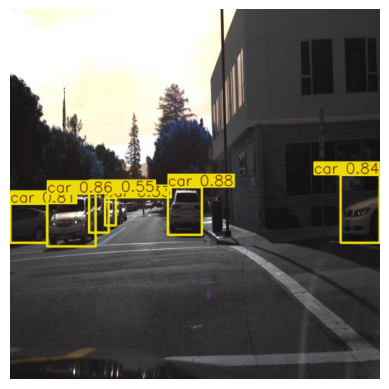


image 1/1 /kaggle/working/training_data/test/images/1478897520221453923_jpg.rf.6ade64ce703357f6bd805fe417e0e787.jpg: 480x480 7 cars, 23.5ms
Speed: 1.6ms preprocess, 23.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 480)
{'x': 150, 'y': 253, 'width': 41, 'height': 52, 'label': 1.0}
{'x': 48, 'y': 259, 'width': 29, 'height': 32, 'label': 1.0}
{'x': 125, 'y': 246, 'width': 20, 'height': 31, 'label': 1.0}
{'x': 140, 'y': 253, 'width': 18, 'height': 30, 'label': 1.0}
{'x': 116, 'y': 247, 'width': 13, 'height': 26, 'label': 1.0}
{'x': 72, 'y': 254, 'width': 15, 'height': 22, 'label': 1.0}
{'x': 109, 'y': 246, 'width': 12, 'height': 24, 'label': 1.0}


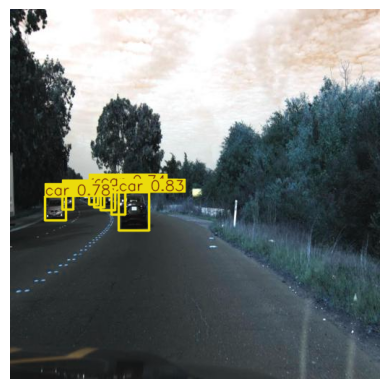


image 1/1 /kaggle/working/training_data/test/images/1478898762205311650_jpg.rf.gOpenah3zCgq3vDkPvha.jpg: 480x480 1 car, 2 trucks, 23.5ms
Speed: 2.2ms preprocess, 23.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 480)
{'x': 459, 'y': 264, 'width': 52, 'height': 40, 'label': 10.0}
{'x': 346, 'y': 269, 'width': 26, 'height': 28, 'label': 10.0}
{'x': 321, 'y': 275, 'width': 19, 'height': 17, 'label': 1.0}


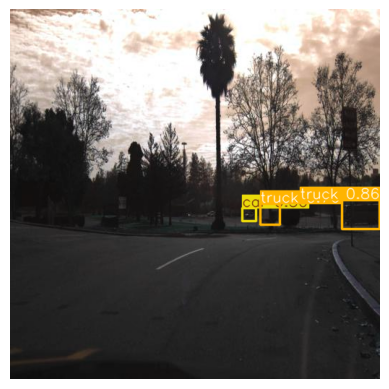


image 1/1 /kaggle/working/training_data/test/images/1478732830206963711_jpg.rf.jZ8zJTdU09n0OlbXEE50.jpg: 480x480 4 cars, 2 trafficLight-Greens, 1 trafficLight-RedLeft, 23.5ms
Speed: 1.5ms preprocess, 23.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 480)
{'x': 284, 'y': 108, 'width': 11, 'height': 30, 'label': 7.0}
{'x': 243, 'y': 230, 'width': 24, 'height': 21, 'label': 1.0}
{'x': 339, 'y': 110, 'width': 10, 'height': 31, 'label': 4.0}
{'x': 218, 'y': 224, 'width': 25, 'height': 19, 'label': 1.0}
{'x': 292, 'y': 231, 'width': 23, 'height': 22, 'label': 1.0}
{'x': 426, 'y': 230, 'width': 18, 'height': 22, 'label': 1.0}
{'x': 480, 'y': 174, 'width': 9, 'height': 27, 'label': 4.0}


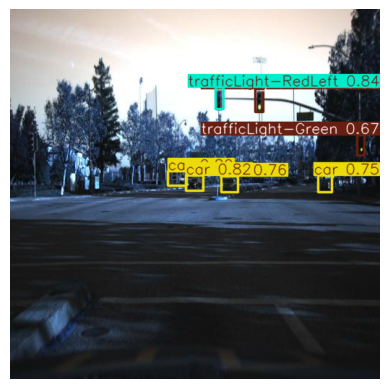


image 1/1 /kaggle/working/training_data/test/images/1478732786049758423_jpg.rf.9be83ba2e7a280b20f590b00400add62.jpg: 480x480 9 cars, 4 trafficLight-Greens, 23.5ms
Speed: 2.1ms preprocess, 23.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 480)
{'x': 429, 'y': 234, 'width': 82, 'height': 182, 'label': 1.0}
{'x': 335, 'y': 214, 'width': 98, 'height': 104, 'label': 1.0}
{'x': 218, 'y': 238, 'width': 16, 'height': 22, 'label': 1.0}
{'x': 311, 'y': 237, 'width': 44, 'height': 58, 'label': 1.0}
{'x': 285, 'y': 217, 'width': 7, 'height': 18, 'label': 4.0}
{'x': 273, 'y': 226, 'width': 6, 'height': 14, 'label': 4.0}
{'x': 236, 'y': 237, 'width': 13, 'height': 19, 'label': 1.0}
{'x': 196, 'y': 240, 'width': 13, 'height': 18, 'label': 1.0}
{'x': 310, 'y': 239, 'width': 29, 'height': 57, 'label': 1.0}
{'x': 245, 'y': 207, 'width': 6, 'height': 15, 'label': 4.0}
{'x': 231, 'y': 204, 'width': 6, 'height': 14, 'label': 4.0}
{'x': 85, 'y': 240, 'width': 22, 'height': 21, 'label': 1.0

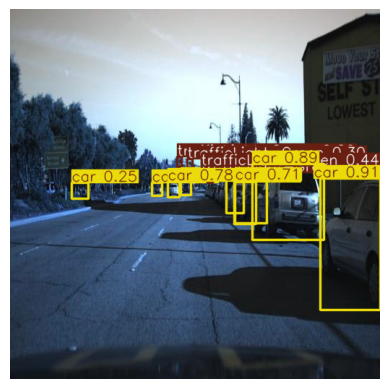

In [4]:
import os
import random
import json
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the trained model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Define the path to your test images directory
test_images_dir = '/kaggle/working/training_data/test/images'  # Adjust the path as necessary

# List all images in the directory
all_images = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith(('.jpg', '.png'))]

# Randomly select 5 images
selected_images = random.sample(all_images, 5)

# List to accumulate results
all_results = []

# Run predictions and visualize results
for img_path in selected_images:
    results = model(img_path)

    formatted_results = []

    for result in results:
        boxes = result.boxes  # get bounding boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()  # coordinates
            confidence = box.conf[0].item()        # confidence score
            class_label = box.cls[0].item()        # class label

            # Convert coordinates to desired format
            width = x2 - x1
            height = y2 - y1
            formatted_result = {
                'x': int(x1),
                'y': int(y1),
                'width': int(width),
                'height': int(height),
                'label': class_label  # You can map this to the actual class name if needed
            }
            formatted_results.append(formatted_result)

    # Add the image path and its results to the accumulated results
    all_results.append({
        'image': img_path,
        'results': formatted_results
    })

#     Print formatted results
    for res in formatted_results:
        print(res)

    # Plot the image with bounding boxes
    for result in results:
        img = result.plot()  # This will plot the bounding boxes and labels on the image
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Save all results to a JSON file
with open('bounding_boxes_results.json', 'w') as f:
    json.dump(all_results, f)


**Compiling Video**

In [5]:
!pip install opencv-python

In [6]:
from ultralytics import YOLO
import os

# Load the trained YOLO model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Directory with the input images
input_images_dir = '/kaggle/working/training_data/test/images'
# Directory to save the images with YOLO predictions
output_images_dir = '/kaggle/working/predictions'
os.makedirs(output_images_dir, exist_ok=True)

# Get all the image filenames, sorted, and then slice to the first 10
image_files = sorted([f for f in os.listdir(input_images_dir) if f.endswith('.jpg') or f.endswith('.png')])[:500]

for image_file in image_files:
    image_path = os.path.join(input_images_dir, image_file)
    
    # Inference
    results = model(image_path)
    
    # Save the resulting image with predictions (YOLOv8 handles bounding boxes automatically)
    save_path = os.path.join(output_images_dir, image_file)
    results[0].save(save_path)



image 1/1 /kaggle/working/training_data/test/images/1478019958682197101_jpg.rf.XCoBnRWpmUTZFpYFGG3Y.jpg: 480x480 7 cars, 1 truck, 23.5ms
Speed: 2.2ms preprocess, 23.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 480)

image 1/1 /kaggle/working/training_data/test/images/1478019960680764792_jpg.rf.110d6e91da348160db1b993d445399ee.jpg: 480x480 5 cars, 23.5ms
Speed: 1.5ms preprocess, 23.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 480)

image 1/1 /kaggle/working/training_data/test/images/1478019961182003465_jpg.rf.6f9292b69d3508b6ab346a907dfae163.jpg: 480x480 2 cars, 23.4ms
Speed: 1.4ms preprocess, 23.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 480)

image 1/1 /kaggle/working/training_data/test/images/1478019962181150666_jpg.rf.230d158a17ea339ca53495e948e85bc7.jpg: 480x480 5 cars, 2 pedestrians, 23.4ms
Speed: 1.3ms preprocess, 23.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 480)

image 1/1 /kaggle/working/training_

In [7]:
import cv2
import os

# Directory where your frames are stored
frames_dir = '/kaggle/working/predictions'
# Name for your output video
output_video = 'yolo_results_video.mp4'

# Get all the frame filenames and sort them
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg') or f.endswith('.png')])

# Read the first frame to get the size
frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # For .mp4 files
out = cv2.VideoWriter(output_video, fourcc, 10.0, (width, height))

# Write frames to video
for frame_file in frame_files:
    frame = cv2.imread(os.path.join(frames_dir, frame_file))
    out.write(frame)

# Release everything
out.release()
# cv2.destroyAllWindows()


In [8]:
import os
print("Video will be saved in:", os.getcwd())


Video will be saved in: /kaggle/working


In [9]:
!pip freeze > requirements.txt
